In [1]:
push!(LOAD_PATH, "./")

using AJSON_IO
using AJSONMesh
using MyGeomUtils
using PyPlot
include("../julia/ConnectedComponent.jl")
include("../julia/symmetrySpectral.jl")
include("../julia/icp.jl")
#using MATLAB

icp (generic function with 3 methods)

In [5]:
 modelpath = "e8927203fbdbe320c02170c33e00ea64.ajson"
#modelpath = "./handbag2/models/model.ajson"
model = loadAJSON(modelpath)

meshList = BuildMeshList(model, 1, eye(4))
newMesh = MergeMeshList(meshList)

vmin = minimum(newMesh.vertices, 1)
vmax = maximum(newMesh.vertices, 1)

center = ((vmax+vmin) * 0.5)
radius = maximum(vmax-vmin) * 0.5

for i=1:length(meshList)
    meshList[i].vertices = (meshList[i].vertices .+ (-center)) / radius
end
newMesh = MergeMeshList(meshList);


In [6]:
compList = []
for mesh in meshList
    mesh = WeldVertices(mesh, 1e-6)
    comps = GetConnectedComponents(mesh)
    for c in comps
        if length(c.faces) > 0            
            push!(compList, c)
        end            
    end
end
meshList = compList;

In [7]:
function mapPointToVoxel(p, minv, maxv, scale)    
    map(Int, ceil((p - minv + 1e-6) / scale))
end

function discretizePoints(points, minv, maxv, scale)
    occupied = Set()    
    for i = 1:size(points, 1)
        v = mapPointToVoxel(points[i, :], minv, maxv, scale)
        push!(occupied, v)
    end
    occupied
end

minv = minimum(newMesh.vertices, 1)
maxv = maximum(newMesh.vertices, 1)
voxres = 30

scale = (maximum(maxv - minv) - 1e-6) / voxres

@time densityProposal = GetSampleDensityProposal(newMesh, 50000)
occupancyList = []
for i = 1:length(meshList)
    points = SamplePoints(meshList[i], densityProposal)
    oc = discretizePoints(points, minv, maxv, scale)
    push!(occupancyList, oc)
end

pointSet = Set()
for i = 1:length(occupancyList)
    union!(pointSet, occupancyList[i])
end

  2.345411 seconds (1.04 M allocations: 34.417 MB, 0.28% gc time)


In [8]:
numPoints = length(pointSet)
bestMeshList = []
iter = 1 
@time begin
    while true
        bestNumGood = 0
        bestMeshId = 0

        println("remaining numPoints: $numPoints")

        for i = 1:length(meshList)
            numGood = length(intersect(occupancyList[i], pointSet))
            if numGood > bestNumGood
                bestNumGood = numGood
                bestMeshId = i
            end
        end

        if bestNumGood < 5
            break
        end
        push!(bestMeshList, bestMeshId)
        
        setdiff!(pointSet, occupancyList[bestMeshId])
        numPoints = length(pointSet)
        iter += 1
    end
end

# minval = minimum(partPoints, 1)
# maxval = maximum(partPoints, 1)

remaining numPoints: 736
remaining numPoints: 471
remaining numPoints: 248
remaining numPoints: 174
remaining numPoints: 145
remaining numPoints: 119
remaining numPoints: 95
remaining numPoints: 75
remaining numPoints: 58
remaining numPoints: 47
remaining numPoints: 36
remaining numPoints: 28
remaining numPoints: 22
remaining numPoints: 17
  0.060659 seconds (53.90 k allocations: 2.178 MB)


In [4]:
function detectSelfSymmetry(Mesh)
    #mesh PCA and normalization
    face = Mesh.faces;
    Cov = zeros(3,3)
    mcenter = zeros(3,1)
    totalarea = 0
    for f in face
        pt1 = vec(Mesh.vertices[f[1],:])
        pt2 = vec(Mesh.vertices[f[2],:])
        pt3 = vec(Mesh.vertices[f[3],:])
        area = norm(cross(pt1-pt2,pt2-pt3))/2
        Cov = Cov + (pt1*pt1' + pt2*pt2' + pt3*pt3' + 0.5*(pt1*pt2' + pt1*pt3' + pt2*pt1' + pt2*pt3' + pt3*pt1' + pt3*pt2')).*area./6
        mcenter = mcenter + area / 3 * (pt1+pt2+pt3)
        totalarea = totalarea + area
    end
    mcenter = mcenter ./ totalarea
    Cov = (Cov ./ totalarea) - mcenter * mcenter'
    eigenval, eigenvec = eig(Cov)
    idx = sortperm(eigenval)
    eigenval = eigenval[idx]
    eigenvec = eigenvec[:,idx]
    Mesh.vertices = Mesh.vertices .- mcenter'
    diag = maximum(Mesh.vertices,1) - minimum(Mesh.vertices,1)
    Mesh.vertices = Mesh.vertices ./ norm(diag) .*2
    eigenval = eigenval ./ (norm(diag)^2) .* 4
    
    #fixed point and PCA
    densityProposal = GetSampleDensityProposal(Mesh, 8000)
    densepoints = SamplePoints(Mesh, densityProposal)
    #points = SamplePoints_Voxelize(densepoints, [-1 -1 -1], [1 1 1], 0.025)
    points = densepoints
    desc = @time(ShapeContext(points, 1.5, 6,6,128))
    dists = pairwise(Euclidean(), desc')
    S = exp(- dists.^2 / 0.02)
    Cs = broadcast(./, S, sum(S,2))
    Xs = deepcopy(points)
    for t = 1:10
        Xs = Cs * Xs
    end
    #pygui(true)
    #figure()
    #scatter3D(points[:,1], points[:,2], points[:,3], s=40, c="b")
    #scatter3D(Xs[:,1], Xs[:,2], Xs[:,3], s=70, c="r")
    Xs_c = mean(Xs, 1)
    Cov = Xs'*Xs./size(Xs, 1) - Xs_c'*Xs_c
    val, dir = eig(Cov)
    idx = sortperm(val)
    val = val[idx]
    dir = dir[:, idx]
    println(val)
    println(dir)
    #suggest promising symmetry
    symType = ""
    canonical_dir = zeros(3,3)
    if val[1] > 0.001
        #no symmetry, return
        println("no symmetry")
        canonical_dir = eigenvec
        points_new = points * canonical_dir
        thirdMoment = sum(points_new.^3, 1)
        for m = 1:3
            if thirdMoment[m]<0
                canonical_dir[:,m]=-canonical_dir[:,m]
            end
        end
        symType = "E"

    elseif val[2] > 0.001
        #reflection normal = first eigenvector
        axis = dir[:,1]
        degree = -1
        axis_f = refineAxis_reflect(densepoints, axis)
        if isempty(axis_f)
            println("error:reflection test failed")
        else
            axis2 = cross(dir[:,3], axis_f)
            axis2 = axis2 ./ norm(axis2)
            axis3 = cross(axis_f, axis2)
            Cov_2 = vcat(axis2', axis3') * Cov * hcat(axis2, axis3)
            val2,dir2 = eig(Cov_2)
            dir2 = dir2[:, sortperm(val2)]
            axis2_f=hcat(axis2, axis3)*dir2[:,1] 
            axis3_f=hcat(axis2, axis3)*dir2[:,2]
            canonical_dir = hcat(axis_f, axis2_f, axis3_f)
            points_new = points * canonical_dir
            thirdMoment = sum(points_new.^3, 1)
            for m = 2:3
                if thirdMoment[m]<0
                    canonical_dir[:,m]=-canonical_dir[:,m]
                end
            end
            symType = "Cs"
        end
    elseif val[3] > 0.001
        #rotation axis = third eigenvector
        axis = dir[:,3]
        degrees, reflectPoses = estimateDegree(densepoints, axis)
        idx = sortperm(vec(degrees), rev=true)
        degrees = degrees[idx]
        reflectPoses = reflectPoses[:,idx]
        degree_f = 0
        axis_f = []
        reflectPose = []
        isreflect_f = false
        for i = 1:size(degrees,1)
            if (i>1) && (degrees[i]==degrees[i-1]) continue; end
            axis_t, reflectPose_t, degree_t, isreflect= refineAxis_C(densepoints, axis, degrees[i], reflectPoses[:,i])
            if degree_t > degree_f 
                degree_f = degree_t
                axis_f = axis_t
                reflectPose = reflectPose_t
                isreflect_f = isreflect
            elseif degree_t == degree_f && isreflect
                axis_f = axis_t
                reflectPose = reflectPose_t
                isreflect_f = isreflect
            end
        end
        
        canonical_dir[:,2] = axis_f
        canonical_dir[:,3] = reflectPose
        canonical_dir[:,3] -= canonical_dir[:,2]*dot(canonical_dir[:,2],canonical_dir[:,3])
        canonical_dir[:,3] /= norm(canonical_dir[:,3])
        canonical_dir[:,1] = cross(canonical_dir[:,2],canonical_dir[:,3]) 
        points_new = points * canonical_dir
        thirdMoment = sum(points_new.^3, 1)
        if thirdMoment[2]<0
            canonical_dir[:,2]=-canonical_dir[:,2]
        end
        symType = "C$(degree_f)"
        if isreflect_f
            symType = symType * "v"
        end

    elseif val[3] <= 0.001
        # higher order symmetry
        if eigenval[1]/eigenval[2] < 0.9 && eigenval[2]/eigenval[3] < 0.9
            degrees = ones(3,1)
            reflect = zeros(3,1)
            for a = 1:3
                axis = eigenvec[:,a]
                reflectPose = zeros(3,1)
                if a<3
                    reflectPose = eigenvec[:,3]
                else
                    reflectPose = eigenvec[:,2]
                end
                canonical_dir[:,a], reflectPose_t, degree_t, isreflect_t = refineAxis_C(densepoints, axis, 2, reflecPose)
                if degree_t == 2 degrees[a]=2; end
                if isreflect_t reflect[a]=1; end
            end
            idx = find(degrees.==2)
            if size(idx,1)==3
                if reflect[1] && reflect[2] && reflect[3]
                    symType = "D2h"
                    elseif !(reflect[1] || reflect[2] || reflect[3])
                    symType = "D2"
                else 
                    println("error resolving symType D2/D2h")
                end
                canonical_dir[:,2]=canonical_dir[:,2] - canonical_dir[:,3]*dot(canonical_dir[:,2],canonical_dir[3])
                canonical_dir[:,2]=canonical_dir[:,2] ./ norm(canonical_dir[:,2])
                canonical_dir[:,1]=cross(canonical_dir[2], canonical_dir[3])
            elseif size(idx,1)==1
                if reflect[idx]
                    symType = "C2v"
                else
                    transform = axis2matrix(canonical_dir[:,idx],-1)
                    points_trans = transform * densepoints'
                    TR,TT,ER,t = icp(densepoints', points_trans, 1, Minimize="point")
                    if ER[1]<0.02
                        symType = "C2h"
                    else
                        symType = "C2"
                    end
                end
                temp = canonical_dir[:,idx]
                canonical_dir[:,idx]=canonical_dir[:,2]
                canonical_dir[:,2]=temp
                canonical_dir[:,3]=canonical_dir[:,3] - canonical_dir[:,2]*dot(canonical_dir[:,2],canonical_dir[3])
                canonical_dir[:,3]=canonical_dir[:,3] ./ norm(canonical_dir[:,3])
                canonical_dir[:,1]=cross(canonical_dir[2], canonical_dir[3])
                points_new = points * canonical_dir
                thirdMoment = sum(points_new.^3, 1)
                if thirdMoment[2]<0
                    canonical_dir[:,2]=-canonical_dir[:,2]
                end
            else 
                println("error resolving symType C2/D2")
            end
        elseif eigenval[1]/eigenval[2] < 0.9 || eigenval[2]/eigenval[3] < 0.9
            if eigenval[1]/eigenval[2] < 0.9
                axis = eigenvec[:,1]
            else 
                axis = eigenvec[:,3]
            end
            degrees, reflectPoses = estimateDegree(densepoints, axis)
            idx = sortperm(vec(degrees), rev=true)
            degrees = degrees[idx]
            reflectPoses = reflectPoses[:,idx]
            degree_f = 0
            axis_f = []
            reflectPose = []
            symType_t = ""
            for i = 1:size(degrees,1)
                if (i>1) && (degrees[i]==degrees[i-1]) continue; end
                axis_t, reflectPose_t, degree_t, symType_t= refineAxis_D(densepoints, axis, degrees[i], reflectPoses[:,i])
                if degree_t > degree_f 
                    degree_f = degree_t
                    axis_f = axis_t
                    reflectPose = reflectPose_t
                    symType = symType_t
                end

                canonical_dir[:,2] = axis_f
                canonical_dir[:,3] = reflectPose
                canonical_dir[:,3] -= canonical_dir[:,2]*dot(canonical_dir[:,2],canonical_dir[:,3])
                canonical_dir[:,3] /= norm(canonical_dir[:,3])
                canonical_dir[:,1] = cross(canonical_dir[:,2],canonical_dir[:,3]) 
            end
        else
            candtrans = symmetrySpectral_short(points,desc)
        end
    end
    println(symType)
    println(canonical_dir)
    #println(candtrans)
    #symtrans, symscores = @time refineTransform(candtrans, densepoints)
    #axises_f, degree_f, reflection_f = processSymmetry(symtrans, symscores)
    #axises_f, degree_f, reflection_f
    symType, canonical_dir, mcenter
end

detectSelfSymmetry (generic function with 1 method)

 23.337537 seconds (67.14 M allocations: 28.366 GB, 10.66% gc time)
[3.163880629413431e-6,0.0005017850762078079,0.11036408859280547]
[-0.0010747960672308123 -0.04316479458211986 -0.9990673877782705
 -0.010627652863993644 -0.9990110492545684 0.043173793693500384
 0.9999429472765015 -0.010664144408713596 -0.0006149926940945748]
[0.0 5.642395217007555 7.0090952409860945 7.360514902813964 5.4607644264760165 4.399534597053879 2.7501993177522808 0.0]
[20 2 2 2 2 2 2 20]
[0.03169410830880675
 0.022608031697005485]
[0.11875149864060398
 0.06671692565441985]
[0.21823605547015024
 0.11402515627577207]
[0.30260464120473873
 0.1785227786332145]
[0.36979587196123126
 0.24429985793346173]
[0.3864455212645702
 0.35430300285967986]
[0.32946182138665553
 0.2003683400774955]
[0.25179132711998137
 0.13788427059421532]
[0.156746944580964
 0.08130274827128747]
[0.06086381572929966
 0.04828008266758565]
[0.03311862315569323
 0.024430632947721034]
[0.11905752694639328
 0.06729182646089438]
[0.218426798254786

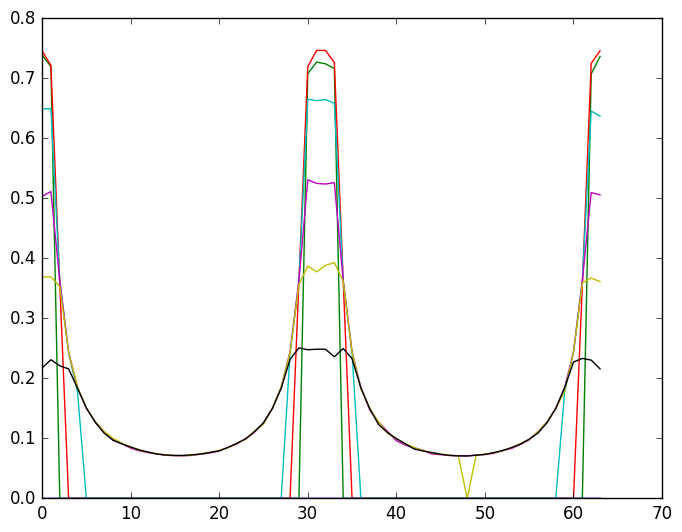

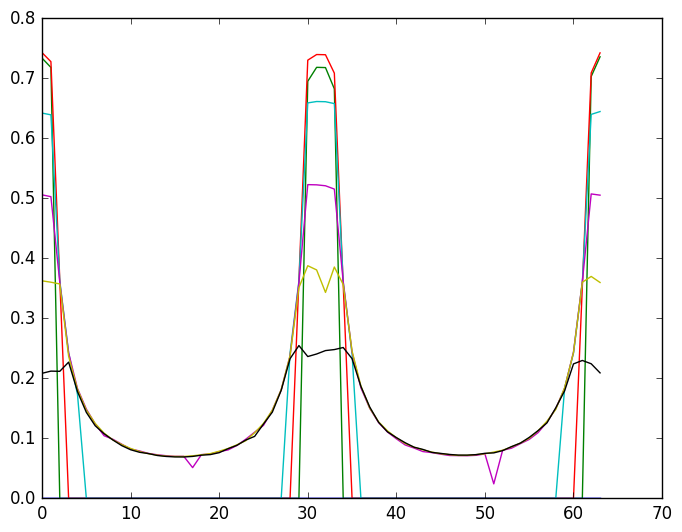

0.995830399736903 0.09111469742108304
 -0.04886440444966272 -0.09122398154558349 0.9946308135025532
 0.9987954460769609 -1.2280521011046432e-5 0.049067878954705775]


In [12]:
#println(bestMeshList)
filename = "SelfSyms.txt"
newMeshList = []
for i = 6:7 #1:size(bestMeshList,1)
    filename = "Part$i"*".obj"
    WriteOBJ(filename, meshList[bestMeshList[i]].vertices, meshList[bestMeshList[i]].faces)
    symType, canonical, mcenter = detectSelfSymmetry(meshList[bestMeshList[i]])
    #fout = open(filename, "w")
    #@printf(fout, "%s\n", symType)
    #@printf(fout, "%f %f %f\n", canonical[1,:]...)
    #@printf(fout, "%f %f %f\n", canonical[2,:]...)
    #@printf(fout, "%f %f %f\n", canonical[3,:]...)
    newpart = deepcopy(meshList[bestMeshList[i]])
    broadcast!(-, newpart.vertices, newpart.vertices, mcenter')
    newpart.vertices = newpart.vertices * canonical
#    filename = "Part$i"*".obj"
#    WriteOBJ(filename, newpart.vertices, newpart.faces)
    push!(newMeshList, newpart)
#    filename = "Part$i"*".sym2"
#    saveSymmetry(filename, axises_f, degree_f, reflection_f)
end

In [10]:
pointclouds = []
descriptors = Array{Float64}(40,0)
densityProposal = GetSampleDensityProposal(newMesh, 50000)
for i = 1:size(newMeshList,1)
    points = SamplePoints(newMeshList[i], densityProposal)
    push!(pointclouds, points)
    desc = D2Descriptor(points, 2000)
    descriptors = hcat(descriptors, desc)
end
dists = pairwise(Euclidean(), descriptors)
for i = 1:size(pointclouds,1)
    for j = i+1:size(pointclouds,1)
        if dists[i,j]<0.05
            TR,TT,ER,t = icp(pointclouds[j]', pointclouds[i]', 50, Minimize = "point")
            println("$i -> $j : ")
            println(TR)
            println(TT)
            println(ER[end])
        end
    end
end
    


1 -> 3 : 
[0.9999831455999867 -0.005764424933790299 -0.0006927634060459459
 0.005765076132320879 0.9999829383945245 0.0009417096368926113
 0.0006873231718787542 -0.0009456875987193904 0.9999993166306774]
[0.004028180004645966
 0.08582041141251728
 -0.0007727446525730184]
0.04192672382447353
1 -> 13 : 
[0.9999501227228695 -0.009934374959528229 0.0010296896010058207
 0.009928696399386299 0.9999362333125302 0.005380547978350823
 -0.0010830763222150458 -0.005370056135833756 0.9999849946088075]
[0.07741884764889662
 0.0004280432851138841
 0.0037952796022793956]
0.0069217646577928015
4 -> 5 : 
[0.999995259237401 -0.00040706441098061895 -0.003052179761005169
 0.00040697196648970755 0.999999916709223 -3.090903916886605e-5
 0.0030521920887552536 2.9666741036999135e-5 0.9999953416108188]
[-0.04190418268245225
 0.06300241051851557
 -0.7695716197762672]
0.008803993399848201
4 -> 8 : 
[0.9999085150618663 -0.00039967112165182066 0.013520420473204583
 0.00041257057928127493 0.9999994624101094 -0.0009

In [13]:
function refineAxis_reflect(points, axis)
    transform = axis2matrix(axis, -1)
    points_trans = transform * points'
    TR,TT,ER,t = icp(points', points_trans, 50, Minimize="point")
    transform = TR * transform
    if ER[1] < 0.03 && ER[end] < 0.02
        axis, angle, reflect = matrix2axis(transform)
        return axis
    end
    return []
end

function refineAxis_C(points, axis, degree, reflectPose)
    transform = axis2matrix(axis, degree)
    baserotation = transform
    basereflection = axis2matrix(cross(axis,reflectPose), -1)
    valid_rotate = zeros(degree,1)
    valid_reflect = zeros(degree,1)
    isreflect = true
    for j = 1:degree
        points_trans = baserotation * points'
        TR,TT,ER,t = icp(points', points_trans, 1, Minimize="point")
        if ER[1] < 0.03 valid_rotate[j]=1; end
        points_trans = basereflection * points'
        TR,TT,ER,t = icp(points', points_trans, 1, Minimize="point")
        println(ER)
        if ER[1] < 0.03 valid_reflect[j]=1; end  
        baserotation = transform * baserotation
        basereflection = transform * basereflection
    end
    degree_f = 1
    idx = 0
    for j = 1:degree
        if mod(degree,j)!= 0 continue; end
        numValid = Int(sum(valid_rotate[j:j:end]))
        if j*numValid == degree 
            degree_f = numValid
            valid_reflect = reshape(valid_reflect, j, numValid)
            numValid2= sum(valid_reflect, 2)
            idx = findfirst(numValid2.==numValid)
            if idx == 0
                isreflect= false
            end    
            break
        end
    end
    transform = axis2matrix(axis, degree_f)
    baserotation = transform
    axis_f = zeros(3,1)
    for j = 1:degree_f
        points_trans = baserotation * points'
        TR,TT,ER,t = icp(points', points_trans, 50, Minimize="point")
        axis_t, degree_t, reflect_t = matrix2axis(TR*baserotation)
        axis_f = axis_f + axis_t;
        baserotation = transform * baserotation
    end
    axis_f = axis_f ./ norm(axis_f)

    if isreflect
        transform = axis2matrix(axis_f, degree)
        basereflection = axis2matrix(cross(vec(axis_f),vec(reflectPose)), -1)
        for j = 1:idx-1
            basereflection = transform * basereflection
        end
        points_trans = basereflection * points'
        TR,TT,ER,t = icp(points', points_trans, 50, Minimize="point")
        axis_t, degree_t, reflect_t = matrix2axis(TR*basereflection)
        reflectPose_f = - cross(vec(axis_f), vec(axis_t))
        if dot(reflectPose_f, reflectPose) < 0
            reflectPose_f = -reflectPose_f
        end
        reflectPose_f = reflectPose_f ./ norm(reflectPose_f)
    else 
        reflectPose_f = reflectPose
    end
    vec(axis_f), vec(reflectPose_f), degree_f, isreflect
end

function refineAxis_D(points, axis, degree, reflectPose)
    axis, reflectPose, degree, isreflect = refineAxis_C(points, axis, degree, reflectPose)
    symType = ""
    transform = axis2matrix(axis,-1)
    points_trans = transform * points'
    TR,TT,ER,t = icp(points', points_trans, 1, Minimize="point")
    if ER[1] < 0.02
        if isreflect
            symType = "D$(degree)h"
        else
            symType = "C$(degree)h"
        end
    else
        transform = axis2matrix(axis, degree)
        halftransform = axis2matrix(axis, 2*degree)
        baseDRotate = axis2matrix(reflectPose,2)
        if isreflect 
            baseDRotate = halftransform * baseDRotate
        end
        valid_D = zeros(degree,1)
        for j = 1:degree
            points_trans = baseDRotate * points'
            TR,TT,ER,t = icp(points', points_trans, 1, Minimize="point")
            if ER[1] < 0.03 valid_D[j]=1; end
            baseDRotate = transform * baseDRotate
        end
        if sum(valid_D[j]==degree)
            if isreflect
                symType = "D$(degree)d"
            else
                symType = "D$(degree)"
            end
        elseif isreflect
            symType = "C$(degree)v"
        else 
            symType = "C$(degree)"
        end
    end

    vec(axis), vec(reflectPose), degree, symType
end

refineAxis_D (generic function with 1 method)

In [3]:
function D2Descriptor(points, numPair, lb=0, ub=2, numBin=40) 
    distance=[]
    numPoints = size(points,1)

    for i = 1:numPair
        v1 = rand(1:numPoints)
        v2 = rand(1:numPoints)
        d = norm(points[v2,:] - points[v1,:])
        push!(distance,d)
    end

    interval = (ub - lb) / numBin + 1e-6
    histogram = zeros(numBin,1)
    for d in distance
        idx = clamp(floor(Int, d/interval)+1, 1, numBin)
        histogram[idx]+=1
    end
    histogram /= numPair
    histogram
end


D2Descriptor (generic function with 4 methods)

In [ ]:
bestMeshList[24]

In [ ]:
Mesh = meshList[216]
    face = Mesh.faces;
    Cov = zeros(3,3)
    mcenter = zeros(3,1)
    totalarea = 0
    for f in face
        pt1 = vec(Mesh.vertices[f[1],:])
        pt2 = vec(Mesh.vertices[f[2],:])
        pt3 = vec(Mesh.vertices[f[3],:])
        area = norm(cross(pt1-pt2,pt2-pt3))/2
        Cov = Cov + (pt1*pt1' + pt2*pt2' + pt3*pt3' + 0.5*(pt1*pt2' + pt1*pt3' + pt2*pt1' + pt2*pt3' + pt3*pt1' + pt3*pt2')).*area./6
        mcenter = mcenter + area / 3 * (pt1+pt2+pt3)
        totalarea = totalarea + area
    end
    mcenter = mcenter ./ totalarea
    Cov = (Cov ./ totalarea) - mcenter * mcenter'
    eigenval, eigenvec = eig(Cov)
    idx = sortperm(eigenval)
    eigenval = eigenval[idx]
    eigenvec = eigenvec[:,idx]
    Mesh.vertices = Mesh.vertices .- mcenter'
    diag = maximum(Mesh.vertices,1) - minimum(Mesh.vertices,1)
    Mesh.vertices = Mesh.vertices ./ norm(diag) .*2
    eigenval = eigenval ./ (norm(diag)^2) .* 4
    
    #fixed point and PCA
    densityProposal = GetSampleDensityProposal(Mesh, 4000)
    densepoints = SamplePoints(Mesh, densityProposal)
    #points = SamplePoints_Voxelize(densepoints, [-1 -1 -1], [1 1 1], 0.025)
    points = densepoints
    desc = @time(ShapeContext(points, 1.5, 6,6,128))
    dists = pairwise(Euclidean(), desc')
    S = exp(- dists.^2 / 0.2)
    Cs = broadcast(./, S, sum(S,2))
    Xs = deepcopy(points)
    for t = 1:5
        Xs = Cs * Xs
    end
    pygui(true)
    figure()
    scatter3D(points[:,1], points[:,2], points[:,3], s=40, c="b")
    scatter3D(Xs[:,1], Xs[:,2], Xs[:,3], s=70, c="r")

In [ ]:
idx = sortperm(points[:,1])
points = points[idx,:]
dists = dists[idx,idx]
imshow(dists*100)
colorbar()